#Group 6: Momentum Residual Neural Networks

By Aiden Turner & Drake Geeteh

Run this to install the momentumnet library

In [ ]:
!pip install momentumnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 6.5 MB/s eta 0:00:00


Imports for libraries that are necessary to run a majority of the code blocks.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from momentumnet import transform_to_momentumnet
import torchvision
from torchvision import transforms
from torch import nn
from momentumnet import MomentumNet
from momentumnet.toy_datasets import make_data

#Accuracy of a Momentum ResNet and classic ResNet on CIFAR-10 and CIFAR-100
By Drake Geeteh

---

This code block will load the training and test sets from the Cifar datasets and then it will train and test a resnet 18 and a momentum resnet 18 with both of these datasets. Then it will create a table demonstrating the test accuracy of both models on both datasets.

The hyper parameters are labeled below and can be adjusted prior to execution.


---


WARNING:
Takes longer than one minute to run


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

Training on CIFAR-10:


Training on CIFAR-100:



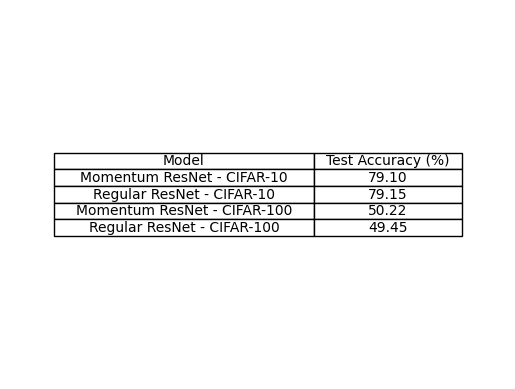

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainloader10 = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    batch_size=32, shuffle=True)

testloader10 = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform),
    batch_size=32, shuffle=False)

trainloader100 = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform),
    batch_size=32, shuffle=True)

testloader100 = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform),
    batch_size=32, shuffle=False)

# Hyperparameters (Appendix E):
# batch = 128
# learning_rate = 0.01
# weight_decay = 5e-4
# epochs = 220
# momentum_value = 0.9
# lr_decay_epoch = 180
# lr_decay_factor = 0.1

# Adjusted hyperparameters
batch_size = 32
learning_rate = 0.02
weight_decay = 5e-4
epochs = 20
momentum_value = 0.9
lr_decay_epoch = 15
lr_decay_factor = 0.1

criterion = torch.nn.CrossEntropyLoss()

def train(model, trainloader, criterion, optimizer, scheduler, epochs):
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        scheduler.step()
    return 100 * correct / total

def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

results = []

for dataset_name, trainloader, testloader in [
    ("CIFAR-10", trainloader10, testloader10),
    ("CIFAR-100", trainloader100, testloader100)
]:
    print(f"\nTraining on {dataset_name}:\n")

    # Momentum ResNet
    resnet = torchvision.models.resnet18(pretrained=False).to('cuda')
    momentum_resnet = transform_to_momentumnet(resnet).to('cuda')

    optimizer = torch.optim.SGD(momentum_resnet.parameters(), lr=learning_rate, momentum=momentum_value, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[lr_decay_epoch], gamma=lr_decay_factor)

    train_accuracy = train(momentum_resnet, trainloader, criterion, optimizer, scheduler, epochs)
    test_accuracy = evaluate(momentum_resnet, testloader)
    results.append((f"Momentum ResNet - {dataset_name}", test_accuracy))

    # ResNet
    resnet = torchvision.models.resnet18(pretrained=False).to('cuda')

    optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate, momentum=momentum_value, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[lr_decay_epoch], gamma=lr_decay_factor)

    train_accuracy = train(resnet, trainloader, criterion, optimizer, scheduler, epochs)
    test_accuracy = evaluate(resnet, testloader)
    results.append((f"Regular ResNet - {dataset_name}", test_accuracy))

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
columns = ["Model", "Test Accuracy (%)"]
table_data = [[name, f"{accuracy:.2f}"] for name, accuracy in results]

table = ax.table(cellText=table_data, colLabels=columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(columns))))

plt.show()

#Memory cost of a Momentum ResNet and a classic ResNet
By Drake Geeteh

---

Run this command to install the memory profiler library that is necessary for the next experiment.

In [ ]:
!pip install memory_profiler

This code block will create Momentum ResNets and a classic ResNets of different depths ranging from 50 to 200 and measure how much space each model occupies in the memory.

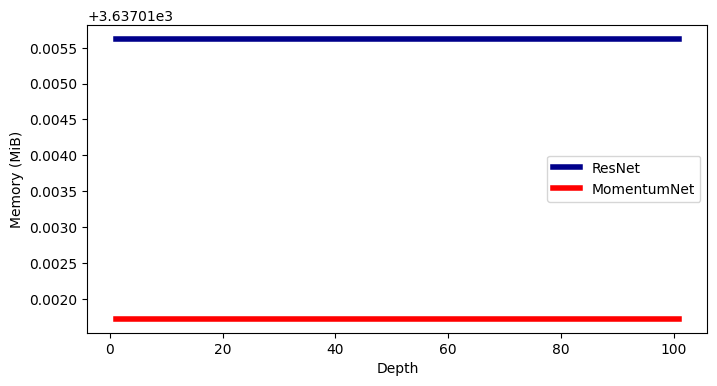

In [ ]:
from memory_profiler import memory_usage

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###########################################
# Fix random seed for reproducible figures
###########################################

torch.manual_seed(1)

##############################
# Parameters of the simulation
##############################

Depths = np.arange(1, 200, 100)


hidden = 1
d = 2

function = nn.Sequential(nn.Linear(d, hidden), nn.Tanh(), nn.Linear(hidden, d))
function_res = nn.Sequential(
    nn.Linear(d, hidden), nn.Tanh(), nn.Linear(hidden, d)
)

X = torch.rand(2, 200000, d)


def train(net):
    Loss = (net(X) ** 2).mean()
    Loss.backward()


Mem_list_mom = []

for n_iters in Depths:

    mom_net = MomentumNet(
        [
            function,
        ]
        * n_iters,
        gamma=1 - 1 / (50 * n_iters),
        init_speed=0,
        use_backprop=False,
    )
    used_mem = np.max(memory_usage((train, (mom_net,))))
    Mem_list_mom.append(used_mem)

Mem_list_res = []

for n_iters in Depths:

    res_net = MomentumNet(
        [
            function_res,
        ]
        * n_iters,
        gamma=0.0,
        init_speed=0,
        use_backprop=True,
    )
    used_mem = np.max(memory_usage((train, (res_net,))))
    Mem_list_res.append(used_mem)

plt.figure(figsize=(8, 4))

plt.plot(Depths, Mem_list_res, label="ResNet", linewidth=4, color="darkblue")
plt.plot(Depths, Mem_list_mom, label="MomentumNet", linewidth=4, color="red")
y_ = plt.ylabel("Memory (MiB)")
x_ = plt.xlabel("Depth")
plt.legend()
plt.show()

#Effects of the momentum term γ

By: Aiden Turner

---

This code block will download the cifar10 training and test sets, then it will make a subset of those datasets using every tenth image and use those to train the models in this experiment. All of the programs in this experiment must be ran in sequence to properly function.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

gammaTrainset = torch.utils.data.Subset(trainset10, np.arange(0, 50000, 10))
gammaTrainset = torch.utils.data.DataLoader(gammaTrainset, batch_size=50, shuffle=True, num_workers=2)

gammaTestset = torch.utils.data.Subset(testset10, np.arange(0, 10000, 10))
gammaTestset = torch.utils.data.DataLoader(gammaTestset, batch_size=50, shuffle=True, num_workers=2)

cost = torch.nn.CrossEntropyLoss()

This code block will create six Momentum ResNet 18 models with momentum values of 0, 0.2, 0.4, 0.6, 0.8, and 1. Each of these models are trained for 8 epochs and then evaluated. This code generates the accuracy scores for the momentum train = momentum test grapth, and should demonstrate that the accuracies of each model should be similar to each other because the momentum value should have no effect on a models accuracy.

---

WARNING: takes longer than one minute to run.

In [ ]:
gammaTestModels = []
gammaTestAcc = []

for x in range(6):
    gammaTestModels.append(transform_to_momentumnet(torchvision.models.resnet18(pretrained=False), gamma = (x*0.2)))

for i, model in enumerate(gammaTestModels):
    opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model.train()

    for epoch in range(8):
        for inputs, labels in gammaTrainset:
            opt.zero_grad()
            outputs = model(inputs)
            loss = cost(outputs, labels)
            loss.backward()
            opt.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in gammaTestset:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    gammaTestAcc.append(100 * correct / total)
    print(f"Model: {i}, accuracy: {100 * correct / total}")

print(gammaTestAcc)

Model: 0, accuracy: 42.3
Model: 1, accuracy: 44.4
Model: 2, accuracy: 43.5
Model: 3, accuracy: 45.8
Model: 4, accuracy: 47.0
Model: 5, accuracy: 45.4
[42.3, 44.4, 43.5, 45.8, 47.0, 45.4]


This code block creates five new models with momentum values of 0, 0.2, 0.4, 0.6, and 0.8, by copying the model from the previous experiment with momentum = 1. These new models are then refit for 3 epochs and then evaluated. This experiment should demonstrate that any model that is being evaluated with a model that has a different momentum value than it was trained with won't have it's test accuracy greatly altered as long as it is refit to the new momentum value.

---

WARNING: takes longer than one minute to run.

In [ ]:
gamma1ReModels = []
gamma1ReAcc = []

for x in range(5):
    gamma1ReModels.append(transform_to_momentumnet(gammaTestModels[5], gamma = (x*0.2)))

for i, model in enumerate(gamma1ReModels):
    opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model.train()

    for epoch in range(3):
        for inputs, labels in gammaTrainset:
            opt.zero_grad()
            outputs = model(inputs)
            loss = cost(outputs, labels)
            loss.backward()
            opt.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in gammaTestset:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    gamma1ReAcc.append(100 * correct / total)
    print(f"Model: {i}, accuracy: {100 * correct / total}")

gamma1ReAcc.append(gammaTestAcc[5])
print(gamma1ReAcc)

Model: 0, accuracy: 47.4
Model: 1, accuracy: 46.9
Model: 2, accuracy: 47.1
Model: 3, accuracy: 47.0
Model: 4, accuracy: 48.3
[47.4, 46.9, 47.1, 47.0, 48.3, 45.4]


This code block creates five new models with momentum values of 0.2, 0.4, 0.6, 0.8, and 1, by copying the model from the previous experiment with momentum = 0. These new models are then refit for 3 epochs and then evaluated. This experiment should demonstrate that the findings of the previous code block are also true for models refit with a momentum value on the other end of the momentum value's range.

---

WARNING: takes longer than one minute to run.

In [ ]:
gamma0ReModels = []
gamma0ReAcc = []

for x in range(5):
    gamma0ReModels.append(transform_to_momentumnet(gammaTestModels[0], gamma = (x*0.2+0.2)))

gamma0ReAcc.append(gammaTestAcc[0])

for i, model in enumerate(gamma0ReModels):
    opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model.train()

    for epoch in range(3):
        for inputs, labels in gammaTrainset:
            opt.zero_grad()
            outputs = model(inputs)
            loss = cost(outputs, labels)
            loss.backward()
            opt.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in gammaTestset:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    gamma0ReAcc.append(100 * correct / total)
    print(f"Model: {i}, accuracy: {100 * correct / total}")

print(gamma0ReAcc)

Model: 0, accuracy: 43.5
Model: 1, accuracy: 44.3
Model: 2, accuracy: 45.3
Model: 3, accuracy: 46.1
Model: 4, accuracy: 43.6
[42.3, 43.5, 44.3, 45.3, 46.1, 43.6]


This code block creates five new models with momentum values of 0, 0.2, 0.4, 0.6, and 0.8, by copying the model from the previous experiment with momentum = 1. These models are then evaluates without refitting to their new momentum values. This experiment is supposed to demonstrate that the momentum term only has an effect on accuracy of the model is being evaluted with a different momentum value than it was trained with. Interestingly, unlike the origional experiment the accuracies of these models are all identical and I have no idea why this could be.

In [ ]:
gamma1Models = []
gamma1Acc = []

for x in range(5):
    gamma1Models.append(transform_to_momentumnet(gammaTestModels[5], gamma = (x*0.2)))

for i, model in enumerate(gamma1Models):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in gammaTestset:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    gamma1Acc.append(100 * correct / total)
    print(f"Model: {i}, accuracy: {100 * correct / total}")

gamma1Acc.append(gammaTestAcc[5])

print(gamma1Acc)

Model: 0, accuracy: 45.4
Model: 1, accuracy: 45.4
Model: 2, accuracy: 45.4
Model: 3, accuracy: 45.4
Model: 4, accuracy: 45.4
[45.4, 45.4, 45.4, 45.4, 45.4, 45.4]


This code block creates five new models with momentum values of 0.2, 0.4, 0.6, 0.8, and 1, by copying the model from the previous experiment with momentum = 0. These models are then evaluates without refitting to their new momentum values. This experiment is supposed to demonstrate that the momentum term only has an effect on accuracy of the model is being evaluted with a different momentum value than it was trained with. Unlike the previous code block, the results of these models parallel that of the authors experiment.

In [ ]:
gamma0Models = []
gamma0Acc = []

for x in range(5):
    gamma0Models.append(transform_to_momentumnet(gammaTestModels[0], gamma = (x*0.2+0.2)))

gamma0Acc.append(gammaTestAcc[0])

for i, model in enumerate(gamma0Models):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in gammaTestset:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    gamma0Acc.append(100 * correct / total)
    print(f"Model: {i}, accuracy: {100 * correct / total}")

print(gamma0Acc)

Model: 0, accuracy: 41.0
Model: 1, accuracy: 35.2
Model: 2, accuracy: 27.4
Model: 3, accuracy: 20.9
Model: 4, accuracy: 15.1
[42.3, 41.0, 35.2, 27.4, 20.9, 15.1]


After running the five previous code blocks, running this code block will generate two diagrams measuring the accuracy of each model set vs the testing momentum values.

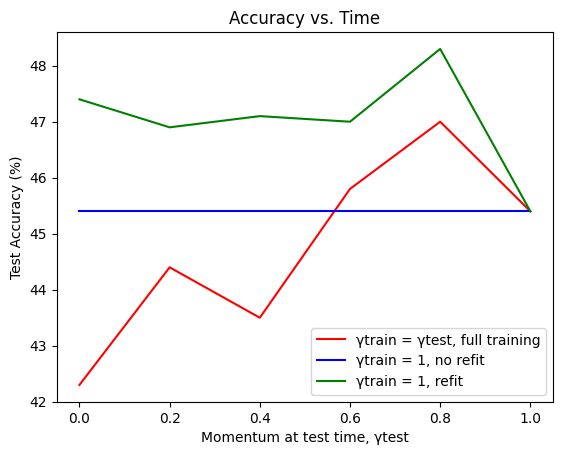

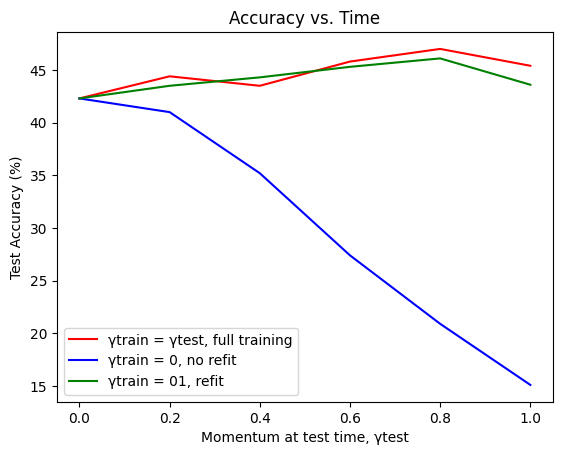

In [ ]:
gammaVal = [0, 0.2, 0.4, 0.6, 0.8, 1]

plt.plot(gammaVal, gammaTestAcc, color='red')
plt.plot(gammaVal, gamma1Acc, color='blue')
plt.plot(gammaVal, gamma1ReAcc, color='green')
plt.legend(['γtrain = γtest, full training','γtrain = 1, no refit','γtrain = 1, refit'])

plt.xlabel("Momentum at test time, γtest")
plt.ylabel("Test Accuracy (%)")
plt.title("Accuracy vs. Time")
plt.show()

plt.plot(gammaVal, gammaTestAcc, color='red')
plt.plot(gammaVal, gamma0Acc, color='blue')
plt.plot(gammaVal, gamma0ReAcc, color='green')
plt.legend(['γtrain = γtest, full training','γtrain = 0, no refit','γtrain = 01, refit'])

plt.xlabel("Momentum at test time, γtest")
plt.ylabel("Test Accuracy (%)")
plt.title("Accuracy vs. Time")
plt.show()

#Plotting seperation of nested rings

By: Aiden Turner

---

Run this code block to set the hyper parameters used by the following two code blocks.

In [ ]:
# Hyper parameters
hiddenLayers = 16
iterations = 10
epochs = 30

lossFun = nn.CrossEntropyLoss()

This code block creates a ResNet and trains it to seperate the points of an artificially generated array of points that form two nested rings, each ring containing points from one class. This code generates a series of plots that should demonstrate the classic ResNet's inability to solve this task by moving the points in seemingly random directions.

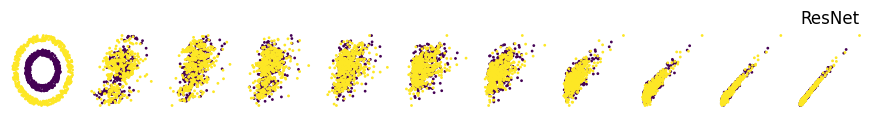

In [ ]:
baseModel = nn.Sequential(nn.Linear(2, hiddenLayers), nn.Tanh(), nn.Linear(hiddenLayers, 2))
nestedRingsModel = MomentumNet([baseModel,] * iterations, gamma = 0)

lrList = np.ones(epochs) * 0.5
opt = torch.optim.Adam(nestedRingsModel.parameters(), lr = lrList[0])

# Training
for i in range(epochs):
    for param_group in opt.param_groups:
        param_group['lr'] = lrList[i]
    opt.zero_grad()
    x0, y0 = make_data(2000,)
    pred0 = nestedRingsModel(x0)
    loss = lossFun(pred0, y0)
    loss.backward()
    opt.step()

# Testing

x1, y1 = make_data(500)

fig, axis = plt.subplots(1, iterations + 1, figsize=(iterations + 1, 1))
plt.title("ResNet")
for i in range(iterations + 1):
    plotNet = MomentumNet([nestedRingsModel,] * i, gamma = 0, init_speed = 0)
    with torch.no_grad():
        pred1 = plotNet(x1)
        axis[i].scatter(pred1[:, 0], pred1[:, 1], c=y1 + 3, s=1)
        axis[i].axis("off")
plt.show()

This code block creates a Momentum ResNet and trains it to seperate the points of an artificially generated array of points that form two nested rings, each ring containing points from one class. This code generates a series of plots that should demonstrate the Momentum ResNet's ability to seperate the nested rings in an efficient manner.

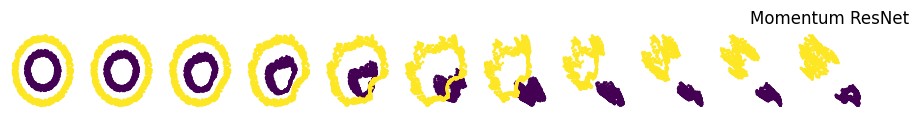

In [ ]:
baseModel = nn.Sequential(nn.Linear(2, hiddenLayers), nn.Tanh(), nn.Linear(hiddenLayers, 2))
momNestedRingsModel = MomentumNet([baseModel,] * iterations, gamma = 0.99)

lrList = np.ones(epochs) * 0.5
opt = torch.optim.Adam(momNestedRingsModel.parameters(), lr = lrList[0])

# Training
for i in range(epochs):
    for param_group in opt.param_groups:
        param_group['lr'] = lrList[i]
    opt.zero_grad()
    x0, y0 = make_data(2000)
    pred0 = momNestedRingsModel(x0)
    loss = lossFun(pred0, y0)
    loss.backward()
    opt.step()

# Testing
x1, y1 = make_data(1000)

fig, axis = plt.subplots(1, iterations + 1, figsize=(iterations + 1, 1))
plt.title("Momentum ResNet")
for i in range(iterations + 1):
    plotNet = MomentumNet([baseModel,] * i, gamma = 0.99, init_speed = 0)
    with torch.no_grad():
        pred1 = plotNet(x1)
        axis[i].scatter(pred1[:, 0], pred1[:, 1], c=y1 + 3, s=1)
        axis[i].axis("off")
plt.show()

#Ability to perform pre-training and fine-tuning

By: Aiden Turner

---

Run the following commands to install the Kaggle library, then use it to download the Hymenoptera dataset, and then finally unzip the dataset so it can be used.

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d ajayrana/hymenoptera-data

Dataset URL: https://www.kaggle.com/datasets/ajayrana/hymenoptera-data
License(s): CC0-1.0
 92% 83.0M/90.2M [00:01<00:00, 81.6MB/s]
100% 90.2M/90.2M [00:01<00:00, 73.5MB/s]


In [ ]:
!unzip /content/hymenoptera-data.zip

Archive:  /content/hymenoptera-data.zip
  inflating: hymenoptera_data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/

This code block defines a class derived from the pyTorch dataset class that can turn the hymenoptera dataset into a dataset that is iterable by a neural network.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert the tensor to a PIL Image
    transforms.Resize((500, 500)),
    transforms.ToTensor(),    # Convert the PIL Image to a float tensor
])

class HymenopteraDataset(Dataset):
    def __init__(self, img_dir, ant, transform=transform, target_transform=None):
        img_files = os.listdir(img_dir)

        if ant:
            self.img_labels = pd.DataFrame({'filename': img_files, 'label': 1000})
        else:
            self.img_labels = pd.DataFrame({'filename': img_files, 'label': 1001})

        #self.img_labels = pd.DataFrame({'filename': img_files, 'label':[1000 if 'ant' in f else 1001 for f in img_files]})
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

This code block assembles the downloaded Hymenoptera datasets into iterable datasets, with the validation dataset being cut down to one third size since this experiment evaluates the model many times over one training epoch.

In [ ]:
ant_train_dataset = HymenopteraDataset(img_dir='/content/hymenoptera_data/train/ants', ant=True)
ant_val_dataset = HymenopteraDataset(img_dir='/content/hymenoptera_data/val/ants', ant=True)
bee_train_dataset = HymenopteraDataset(img_dir='/content/hymenoptera_data/train/bees', ant=False)
bee_val_dataset = HymenopteraDataset(img_dir='/content/hymenoptera_data/val/bees', ant=False)

hym_train_dataset = torch.utils.data.ConcatDataset([ant_train_dataset, bee_train_dataset])
hym_val_dataset = torch.utils.data.ConcatDataset([ant_val_dataset, bee_val_dataset])
hym_val_dataset = torch.utils.data.Subset(hym_val_dataset, np.arange(0, 153, 3))

hym_train = torch.utils.data.DataLoader(hym_train_dataset, batch_size=4, shuffle=True, num_workers=2)
hym_val = torch.utils.data.DataLoader(hym_val_dataset, batch_size=4, shuffle=True, num_workers=2)

This code block imports the time library and uses it to create a handy timer class that the next two code blocks use to measure time.

In [ ]:
import time

class Timer:
    def __init__(self):
        self.startTime = time.time()
        self.timeStamps = []

    def timeStamp(self):
        self.timeStamps.append(time.time() - self.startTime)

    def pauseTimer(self):
        self.stopTime = time.time()

    def resumeTimer(self):
        self.startTime += (time.time() - self.stopTime)

    def getStamps(self):
        return self.timeStamps

    def getTimeStamp(self, x):
        return self.timeStamps[x]

This code block creates a Momentom ResNet 34 model pretrained on the ImageNet database. This model is trained on the Hymenoptera dataset for one epoch, and after every 5 batches the code takes a time stamp, pauses the timer, and evaluates the model to measure the accuracy at that point in the training time.

---

WARNING: takes longer than one minute to run.

In [ ]:
hym_train = torch.utils.data.DataLoader(hym_train_dataset, batch_size=4, shuffle=True, num_workers=2)
hym_val = torch.utils.data.DataLoader(hym_val_dataset, batch_size=10, shuffle=True, num_workers=2)

hymenoptera34 = torchvision.models.resnet34(weights='ResNet34_Weights.DEFAULT')
hymenoptera34.fc = torch.nn.Linear(hymenoptera34.fc.in_features, 1002)
hymenoptera34 = transform_to_momentumnet(hymenoptera34, gamma = 0.9)

cost = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(hymenoptera34.parameters(), lr=0.0005, momentum=0.9)

accuracy = []

timer = Timer()

for i, data in enumerate(hym_train, 0):
    inputs, labels = data

    if i % 5 == 0:
        timer.timeStamp()
        timer.pauseTimer()

        hymenoptera34.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for val in hym_val:
                val_input, val_labels = val
                outputs = hymenoptera34(val_input)
                _, predicted = torch.max(outputs.data, 1)
                print(predicted)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()

        print(f"batch: {i}, time: {timer.getTimeStamp(i//5):.2f} accuracy: {100 * correct / total:.2f}%")
        accuracy.append(100 * correct / total)

        hymenoptera34.train()
        timer.resumeTimer()

    opt.zero_grad()
    outputs = hymenoptera34(inputs)
    loss = cost(outputs, labels)
    loss.backward()
    opt.step()

times = timer.getStamps()

print(times)
print(accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 157MB/s]


tensor([652, 652,  84, 885, 634, 652, 652, 652, 885, 652])
tensor([885, 885, 885, 652, 652, 885, 652, 771, 652,  84])
tensor([652, 885, 997, 885, 652,  84, 885,  84, 652, 652])
tensor([652, 885, 885, 885, 652,  84, 885, 885, 652, 885])
tensor([652, 885, 885, 753, 652, 652,  84, 885, 885, 652])
tensor([84])
batch: 0, time: 0.25 accuracy: 0.00%
tensor([885,  84, 652, 885, 868, 269, 885, 885,  84, 652])
tensor([885, 885, 652, 652, 269, 885, 652, 885, 997, 771])
tensor([885, 652, 885, 652, 885, 885, 271, 269, 269, 269])
tensor([885,  90, 269, 652, 652, 885, 269, 271, 683, 885])
tensor([885, 271, 885, 652, 885, 885, 885,  84,  84, 771])
tensor([885])
batch: 5, time: 72.59 accuracy: 0.00%
tensor([1001, 1000, 1001, 1001, 1001, 1001,   84,  885, 1001,   84])
tensor([1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001])
tensor([1000, 1001,  885,  885,  271, 1001, 1001, 1001,  271, 1001])
tensor([1000,   57, 1001, 1001, 1001, 1001, 1001, 1001, 1000, 1001])
tensor([1001, 1001, 1001,  997, 

This code block creates a classic ResNet 34 model pretrained on the ImageNet database. This model is trained on the Hymenoptera dataset for one epoch, and after every 10 batches the code takes a time stamp, pauses the timer, and evaluates the model to measure the accuracy at that point in the training time. This model is evaluated every 10 batches because the origional authors used a batch size of 2 to train their ResNet and a batch size of 4 for their Momentum ResNet.

---

WARNING: takes longer than one minute to run.

In [ ]:
hym_train = torch.utils.data.DataLoader(hym_train_dataset, batch_size=2, shuffle=True, num_workers=2)
hym_val = torch.utils.data.DataLoader(hym_val_dataset, batch_size=10, shuffle=True, num_workers=2)

hymenoptera34 = torchvision.models.resnet34(weights='ResNet34_Weights.DEFAULT')
hymenoptera34.fc = torch.nn.Linear(hymenoptera34.fc.in_features, 1002)

cost = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(hymenoptera34.parameters(), lr=0.0005, momentum=0.9)

accuracy_ = []

timer_ = Timer()


for i, data in enumerate(hym_train, 0):
    inputs, labels = data

    if i % 10 == 0:
        timer_.timeStamp()
        timer_.pauseTimer()

        hymenoptera34.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for val in hym_val:
                val_input, val_labels = val
                outputs = hymenoptera34(val_input)
                _, predicted = torch.max(outputs.data, 1)
                print(predicted)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()

        print(f"batch: {i}, time: {timer_.getTimeStamp(i//10):.2f} accuracy: {100 * correct / total:.2f}%")
        accuracy_.append(100 * correct / total)

        hymenoptera34.train()
        timer_.resumeTimer()

    opt.zero_grad()

    outputs = hymenoptera34(inputs)
    loss = cost(outputs, labels)
    loss.backward()
    opt.step()

times_ = timer_.getStamps()

tensor([772, 772,  84, 772,  84,  84, 879, 434, 772, 650])
tensor([354,  84, 713, 434, 879, 155, 896, 434, 772, 434])
tensor([434, 289, 772, 627, 378, 627, 833, 434, 537, 627])
tensor([616, 450, 450, 450, 450, 772, 280, 627, 434, 291])
tensor([434, 650, 434, 561, 772, 434, 434, 896, 291, 627])
tensor([537])
batch: 0, time: 0.15 accuracy: 0.00%
tensor([1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001])
tensor([1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001])
tensor([1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001])
tensor([1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001])
tensor([1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001])
tensor([1001])
batch: 10, time: 41.32 accuracy: 52.94%
tensor([1001, 1001, 1001, 1001, 1001, 1001, 1001, 1000, 1001, 1001])
tensor([1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001])
tensor([1001, 1001, 1000, 1001, 1001, 1001, 1001, 1001, 1001, 1001])
tensor([1001, 1001, 1001, 1001, 1001, 1001, 100

This code block creates a graph comparing the test accuracy vs training time of the two models. This graph should demonstrate the classic ResNet and Momentum ResNet's ability to achieve a high accuracy over a relatively short training time. Another thing to note is how the classic ResNet fluctuates a lot more than the Momentume ResNet despite using almost the exact same hyperparameters, demonstrating the Momentum ResNet's ability to converge faster.

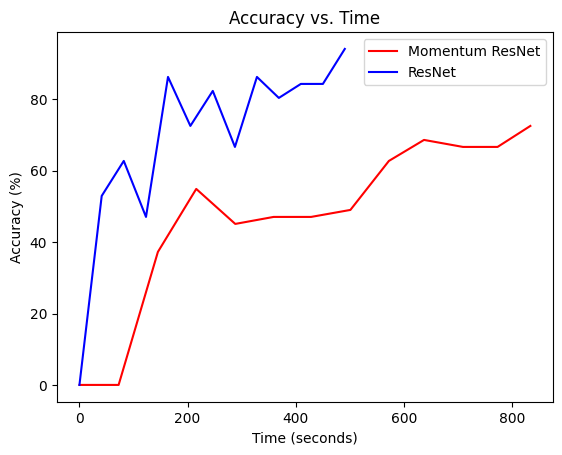

In [ ]:
plt.plot(times, accuracy, color='red')
plt.plot(times_, accuracy_, color='blue')
plt.legend(['Momentum ResNet', 'ResNet'])
plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Time")
plt.show()